# **Capgemini Datachallenge 2025**


In [1]:
%load_ext autoreload
%autoreload 2
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from codecarbon import EmissionsTracker
import time


In [2]:
PROJECT_ROOT = Path().cwd().parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src2.utils.pipeline import (
    LagFeatureGeneratorNoMultiIndex,
    create_non_linear_features,
)


INPUT_DIR = PROJECT_ROOT / "data/input"
EVAL_DIR = PROJECT_ROOT / "data/evaluation"

# EXPLORATION SEED
EXPLORATION_SEED = 42

datasets = {"train": INPUT_DIR, "eval": EVAL_DIR}

data = {}
for split, dir in datasets.items():
    data[split] = pd.read_csv(dir / f"dataset_baseline.csv")

FEAT_TO_DROP = [
    "is_winter",
    "is_spring",
    "is_summer",
    "is_autumn",
    "is_jan",
    "is_feb",
    "is_mar",
    "is_apr",
    "is_may",
    "is_jun",
    "is_jul",
    "is_aug",
    "is_sep",
    "is_oct",
    "is_nov",
    "is_dec",
    # "area",
]

# --- Config ---
TARGETS = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    # "water_flow_week4",
]
TO_DROP = TARGETS + ["station_code", "ObsDate", "water_flow_week4"]

# QUANTILES = [0.1, 0.5, 0.9]
QUANTILES = [0.5]
# X_cols = DYNAMIC_COLUMNS + STATIC_COLUMNS


NUMBER_OF_WEEK = 3
# TIME_VALIDATION = "2000-01-01 00:00:00"
# TOTAL_STATIONS = 39

In [3]:
# Add calendar features (cylic month + seasons)
def calendar_features(dates: pd.Series) -> pd.DataFrame:
    m = dates.dt.month
    days = dates.dt.day
    weeks = dates.dt.isocalendar().week
    # cyclical month
    cal = pd.DataFrame(
        {
            "month_sin": np.sin(2 * np.pi * (m / 12.0)),
            "month_cos": np.cos(2 * np.pi * (m / 12.0)),
            "sin_dayofyear": np.sin(2 * np.pi * days / 365.25),
            "cos_dayofyear": np.cos(2 * np.pi * days / 365.25),
            "sin_weekofyear": np.sin(2 * np.pi * weeks / 52.0),
            "cos_weekofyear": np.cos(2 * np.pi * weeks / 52.0),
        },
        index=dates.index,
    )
    return cal


def display_columns_square(df):
    """
    Displays the column names of a pandas DataFrame in a square-like table format.

    Args:
        df (pd.DataFrame): The DataFrame to process.
    """
    column_names = df.columns.tolist()
    column_names = sorted(column_names)
    num_cols = len(column_names)

    if num_cols == 0:
        print("The DataFrame has no columns.")
        return

    # 1. Calculate the dimensions for the square table
    # The number of rows and columns is the ceiling of the square root of num_cols
    import math

    table_dimension = math.ceil(np.sqrt(num_cols))

    # 2. Reshape the column names into the table structure
    # Determine the number of empty cells needed to fill the grid
    total_cells = table_dimension * table_dimension
    padding = total_cells - num_cols

    # Add empty strings for padding (if needed)
    padded_names = column_names + [""] * padding

    # Convert the list into a numpy array and reshape it into the square matrix
    # The order is filled row by row
    square_array = np.array(padded_names).reshape(table_dimension, table_dimension)

    # 3. Convert the numpy array back into a pandas DataFrame for a clean table output
    table_df = pd.DataFrame(square_array)

    print("✨ Column Names in Square Table Format:")
    # Display the DataFrame without index or header for a cleaner look
    print(table_df.to_string(index=False, header=False))


# Fix Latitude and Longitude
dataset_baseline = {}
for split, dir in datasets.items():
    path_data_baseline_france = dir / f"preprocessed_france.csv"
    dataset_baseline_france = pd.read_csv(path_data_baseline_france)

    dataset_baseline_france = dataset_baseline_france.iloc[:, 1:]
    dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])

    dataset_baseline_france = dataset_baseline_france.set_index("ObsDate")

    path_data_baseline = dir / f"preprocessed_brazil.csv"
    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:, 1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = dataset_baseline_brazil.set_index("ObsDate")

    dataset_baseline_france["north_hemisphere"] = 1
    dataset_baseline_brazil["north_hemisphere"] = 0

    dataset_baseline[split] = pd.concat(
        [dataset_baseline_france, dataset_baseline_brazil], axis=0
    )

    data[split]["latitude"] = dataset_baseline[split]["latitude"].values
    data[split]["longitude"] = dataset_baseline[split]["longitude"].values

    # Add additional calendar features
    data_calendar_features = calendar_features(pd.to_datetime(data[split]["ObsDate"]))
    data[split] = pd.concat([data[split], data_calendar_features], axis=1)


dataset_train = data["train"].copy()
dataset_test = data["eval"].copy()

# sort
dataset_train = dataset_train.sort_values(by=["station_code", "ObsDate"]).reset_index(
    drop=True
)
dataset_test = dataset_test.sort_values(by=["station_code", "ObsDate"]).reset_index(
    drop=True
)

# drop features
dataset_train = dataset_train.drop(columns=FEAT_TO_DROP)
dataset_test = dataset_test.drop(columns=FEAT_TO_DROP)

display_columns_square(dataset_train)

✨ Column Names in Square Table Format:
                            ObsDate                          altitude       bdod_0-5cm_mean_index__region       bdod_0-5cm_mean_index__sector     bdod_0-5cm_mean_index__sub_sector           bdod_0-5cm_mean_index__zone  bdod_100-200cm_mean_index__region     bdod_100-200cm_mean_index__sector bdod_100-200cm_mean_index__sub_sector     bdod_100-200cm_mean_index__zone      bdod_15-30cm_mean_index__region      bdod_15-30cm_mean_index__sector bdod_15-30cm_mean_index__sub_sector
      bdod_15-30cm_mean_index__zone   bdod_30-60cm_mean_index__region     bdod_30-60cm_mean_index__sector bdod_30-60cm_mean_index__sub_sector         bdod_30-60cm_mean_index__zone        bdod_5-15cm_mean_index__region     bdod_5-15cm_mean_index__sector    bdod_5-15cm_mean_index__sub_sector          bdod_5-15cm_mean_index__zone    bdod_60-100cm_mean_index__region     bdod_60-100cm_mean_index__sector bdod_60-100cm_mean_index__sub_sector      bdod_60-100cm_mean_index__zone
           

## LGBM Model


In [4]:
# --- Training functions ---
def process_df(df):
    df = df.sort_values(by=["ObsDate", "station_code"]).reset_index(drop=True)

    # ✅ Fix: correct lag column name
    lagger = LagFeatureGeneratorNoMultiIndex(
        lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        cols_to_lag=[
            "water_flow_lag_1w",  # fixed name
            "temperatures",
            "soil_moisture",
            "precipitations",
            "evaporation",
        ],
    )
    df = lagger.transform(df, group_col="station_code", datetime_col="ObsDate")

    df = create_non_linear_features(df)

    # rolling features
    for col in ["temperatures", "soil_moisture", "precipitations", "evaporation"]:
        for w in [3, 5, 7, 9]:
            grp = df.groupby("station_code")[col]
            df[f"{col}_roll_mean_{w}w"] = grp.transform(
                lambda x: x.rolling(w, 1).mean()
            )
            df[f"{col}_roll_std_{w}w"] = grp.transform(
                lambda x: x.rolling(w, 1).std()
            ).fillna(0)

    return df


def evaluate_results(results, preds_key="regression"):
    out = []
    for target, res in results.items():
        y_true = res["true"]
        y_pred_med = res["preds"][preds_key]
        mse = mean_squared_error(y_true, y_pred_med)
        mae = mean_absolute_error(y_true, y_pred_med)
        out.append(
            {"target": target, f"MSE ({preds_key})": mse, f"MAE ({preds_key})": mae}
        )
    return pd.DataFrame(out)


def carbon_analysis(carbon_results, MODEL_DIR=None):
    # Display carbon footprint results
    carbon_df = pd.DataFrame(carbon_results)
    carbon_summary = (
        carbon_df.groupby("model")
        .agg(
            {
                "duration_seconds": ["mean", "sum"],
                "emissions_kg": ["mean", "sum"],
                "cpu_energy_kwh": ["mean", "sum"],
            }
        )
        .round(6)
    )

    print("\n=== COMPUTATIONAL COST SUMMARY ===")
    print(carbon_summary)

    # Save for paper
    # carbon_df.to_csv(f"{MODEL_DIR}carbon_footprint.csv", index=False)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    # Training time by model
    carbon_df.groupby("model")["duration_seconds"].sum().plot(kind="bar", ax=axes[0])
    axes[0].set_title("Total Training Time (seconds)")
    axes[0].set_ylabel("Time (s)")

    # Energy consumption
    carbon_df.groupby("model")["cpu_energy_kwh"].sum().plot(kind="bar", ax=axes[1])
    axes[1].set_title("Total Energy Consumption")
    axes[1].set_ylabel("kWh")

    plt.tight_layout()
    # plt.savefig(f"{MODEL_DIR}computational_cost.png", dpi=300, bbox_inches='tight')
    plt.show()


from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit


def log_transform(y):
    return np.log1p(y)  # log(1 + y) to handle zeros


def inverse_log_transform(y):
    return np.expm1(y)  # exp(y) - 1 to reverse log(1 + y)


# import transformedtargetregressor
from sklearn.compose import TransformedTargetRegressor


def build_regression_lgbm(params=None, seed=EXPLORATION_SEED):
    params = {} if params is None else params.copy()
    if "random_state" not in params:
        params["random_state"] = seed
    return LGBMRegressor(**params, n_jobs=-1, verbosity=-1)


def build_quantile_lgbm(alpha, params=None, seed=EXPLORATION_SEED):
    params = {} if params is None else params.copy()
    if "random_state" not in params:
        params["random_state"] = seed
    params.update({"objective": "quantile", "alpha": alpha})
    return LGBMRegressor(**params, n_jobs=-1, verbosity=-1)


from xgboost import XGBRegressor


def build_xgboost(alpha=0.5, params=None, seed=EXPLORATION_SEED):
    params = {} if params is None else params.copy()
    if "random_state" not in params:
        params["random_state"] = seed
    params.update({"objective": "reg:squarederror"})
    return XGBRegressor(**params, n_jobs=-1, verbosity=0)


def build_model(type_model, alpha=None, params=None, seed=EXPLORATION_SEED):
    if type_model == "lgbm_quantile":
        return build_quantile_lgbm(alpha, params=params, seed=seed)
    elif type_model == "lgbm_regression":
        return build_regression_lgbm(params=params, seed=seed)
    elif type_model == "xgb_regression":
        return build_xgboost(params=params, seed=seed)
    else:
        raise ValueError(f"Unknown model type: {type_model}")


from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectFromModel


def build_wrapped_model_target_transf(base_model):
    # 1. Imputer step: Named 'imputer' to match the search space key 'imputer__strategy'
    # Default strategy is 'median', but RandomizedSearchCV will tune this.
    imputer_estimator = SimpleImputer(strategy="median")

    # 2. Selector step: Named 'selector' to match the search space key 'selector__threshold'
    # We define a separate, fixed-hyperparameter XGBRegressor for fast feature importance calculation.
    selection_base_estimator = XGBRegressor(
        n_estimators=100,
        random_state=base_model.random_state,
        n_jobs=-1,
        verbosity=0,  # Suppress XGBoost output during selection fitting
    )

    # SelectFromModel uses the importance generated by the selection_base_estimator
    selector_estimator = SelectFromModel(
        estimator=selection_base_estimator,
        # Set a default threshold, which the grid search will override/tune via 'selector__threshold'
        threshold="mean",
        prefit=False,
    )
    # 1. Define the TransformedTargetRegressor step (your original estimator)
    ttreg_estimator = TransformedTargetRegressor(
        regressor=base_model,
        func=log_transform,
        inverse_func=inverse_log_transform,
    )

    # 2. Wrap the selector and the model into a Pipeline
    #    - 'selector': This step is named 'selector' to match the 'selector__k' key.
    #    - 'model': This step is named 'model' to match the 'model__regressor__' keys.
    estimator = Pipeline(
        [
            ("imputer", imputer_estimator),
            ("selector", selector_estimator),
            ("model", ttreg_estimator),
        ]
    )
    return estimator


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Define the early stopping callback
# import lgb
import lightgbm as lgb

early_stopping_callback = lgb.early_stopping(
    stopping_rounds=50,  # Stops if val score doesn't improve for 50 rounds
    verbose=True,
)


def fit_model(model, Xtr, ytr, tracker_name):
    tracker = EmissionsTracker(
        project_name=tracker_name,
        measure_power_secs=1,
        tracking_mode="process",
        log_level="WARNING",
        save_to_file=False,
    )
    tracker.start()
    start_time = time.time()

    # NOTE: eval_set and callbacks removed as Xva/yva are no longer available
    model.fit(Xtr, ytr)

    emissions_kg = tracker.stop()

    duration = time.time() - start_time

    # Accessing final_emissions_data might vary based on codecarbon version; assuming it works.
    energy_kwh = tracker.final_emissions_data.energy_consumed

    # Predict on the training split (Xtr)
    preds = model.predict(Xtr)
    carbon_results = {
        "duration_seconds": duration,
        "emissions_kg": emissions_kg,
        "cpu_energy_kwh": energy_kwh,
    }
    return preds, model, carbon_results


def get_lgbm_param_dist():
    """
    Defines the hyperparameter search space for RandomizedSearchCV.
    Parameters are prefixed with 'regressor__' because we are tuning
    a model inside a TransformedTargetRegressor.
    """
    return {
        # "regressor__n_estimators": randint(400, 600),  # 400, 500, 600
        # "regressor__n_estimators": [400, 500, 600, 700],  # 400, 500, 600
        # "regressor__n_estimators": [1000, 1200],  # 400, 500, 600
        "regressor__n_estimators": randint(50, 51),  # DEBUG
        "regressor__learning_rate": uniform(0.01, 0.05),
        "regressor__max_depth": randint(3, 6),
        "regressor__num_leaves": randint(20, 40),
        "regressor__min_data_in_leaf": randint(30, 100),
        "regressor__feature_fraction": uniform(
            0.6, 0.3
        ),  # Base 0.6, range 0.3 -> [0.6, 0.9]
        "regressor__bagging_fraction": uniform(0.6, 0.3),
        "regressor__reg_lambda": uniform(1.0, 10.0),
        "regressor__reg_alpha": uniform(0.0, 10.0),
    }


# def get_xgb_param_dist_full():
#     """
#     Defines the hyperparameter search space for XGBoost (XGBRegressor)
#     within a RandomizedSearchCV context, assuming the estimator is a
#     Pipeline([('selector', SelectKBest), ('model', TransformedTargetRegressor)]).

#     Parameters are prefixed with 'model__regressor__' to align with the
#     nested Pipeline structure.
#     """
#     return {
#         # --- FEATURE SELECTION PARAMETER ADDED ---
#         # Tunes the number of features (k) to select using SelectKBest/SelectPercentile
#         # "selector__k": randint(
#         #     70, 200
#         # ),  # Example: tune number of features from 20 to 99
#         "selector__threshold": ["mean", "median"],
#         # --- END FEATURE SELECTION PARAMETER ---
#         # The inner model parameters are now prefixed with 'model__regressor__'
#         # --- OBJECTIVE PARAMETER MODIFIED ---
#         "model__regressor__objective": ["reg:squarederror", "reg:pseudohubererror"],
#         # --- END OBJECTIVE PARAMETER ---
#         # General Parameters
#         # n_estimators (Number of trees/boosting rounds) - Matches LightGBM
#         "model__regressor__n_estimators": randint(
#             50, 51
#         ),  # DEBUG (Use a wider range for production)
#         # "model__regressor__n_estimators": randint(500, 1500),
#         # learning_rate (eta) - Matches LightGBM
#         "model__regressor__learning_rate": uniform(0.01, 0.1),
#         # Tree Structure Control
#         # max_depth - Matches LightGBM
#         "model__regressor__max_depth": randint(3, 6),
#         # min_child_weight: Controls the minimum sum of instance weight (Hessian)
#         "model__regressor__min_child_weight": randint(1, 10),
#         # Subsampling (Injecting randomness to prevent overfitting)
#         # feature_fraction (LightGBM) is equivalent to colsample_bytree (XGBoost)
#         "model__regressor__colsample_bytree": uniform(0.6, 0.3),  # [0.6, 0.9]
#         # bagging_fraction (LightGBM) is equivalent to subsample (XGBoost)
#         "model__regressor__subsample": uniform(0.6, 0.3),  # [0.6, 0.9]
#         # Regularization Parameters
#         # reg_lambda (L2 regularization) - Matches LightGBM
#         "model__regressor__reg_lambda": uniform(1.0, 10.0),
#         # reg_alpha (L1 regularization) - Matches LightGBM
#         "model__regressor__reg_alpha": uniform(0.0, 10.0),
#     }


# simple run
def get_xgb_param_dist():
    """
    Defines the hyperparameter search space for XGBoost (XGBRegressor)
    within a RandomizedSearchCV context, assuming the estimator is a
    Pipeline([('imputer', SimpleImputer), ('selector', SelectFromModel), ('model', TransformedTargetRegressor)]).

    Parameters are prefixed correctly to align with the nested Pipeline structure.
    """
    return {
        # --- FEATURE SELECTION & IMPUTATION PARAMETERS ---
        # SelectFromModel tunes the selection threshold, not 'k'.
        "selector__threshold": ["median"],
        "imputer__strategy": ["median", "mean"],
        # --- END FEATURE SELECTION & IMPUTATION PARAMETERS ---
        # The inner model parameters are now prefixed with 'model__regressor__'
        # --- OBJECTIVE PARAMETER MODIFIED ---
        # Narrowing the objective function choice after initial tuning
        "model__regressor__objective": ["reg:pseudohubererror"],
        # --- END OBJECTIVE PARAMETER ---
        # General Parameters
        # n_estimators (Number of trees/boosting rounds) - Using the better, wider range
        "model__regressor__n_estimators": randint(1000, 2000),
        # learning_rate (eta) - Adjusted to focus on higher values based on previous tuning results (Range: [0.07, 0.17])
        "model__regressor__learning_rate": uniform(0.05, 0.1),
        # Tree Structure Control
        # max_depth - Matches LightGBM equivalent
        "model__regressor__max_depth": randint(3, 6),
        # min_child_weight: Controls the minimum sum of instance weight (Hessian)
        "model__regressor__min_child_weight": randint(1, 11),
        # Subsampling (Injecting randomness to prevent overfitting)
        # feature_fraction (LightGBM) is equivalent to colsample_bytree (XGBoost)
        "model__regressor__colsample_bytree": uniform(0.6, 0.3),  # [0.6, 0.9]
        # bagging_fraction (LightGBM) is equivalent to subsample (XGBoost)
        "model__regressor__subsample": uniform(0.6, 0.3),  # [0.6, 0.9]
        # Regularization Parameters
        # reg_lambda (L2 regularization) - Matches LightGBM
        "model__regressor__reg_lambda": uniform(1.0, 12.0),
        # reg_alpha (L1 regularization) - Matches LightGBM
        "model__regressor__reg_alpha": uniform(0.0, 12.0),
    }


from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit


def find_best_params(X_train, y_train, n_iter=40, cv_splits=5):
    print("  Running RandomizedSearchCV (no fit-time callbacks)...")

    # base_model = build_quantile_lgbm(alpha=0.5)
    base_model = build_model(type_model="xgb_regression", alpha=0.5)
    # base_model = build_regression_lgbm()

    estimator = build_wrapped_model_target_transf(base_model)

    # param_dist = get_lgbm_param_dist()  # uses "regressor__<param>" keys — OK
    param_dist = get_xgb_param_dist()  # uses "model__regressor__<param>" keys — OK

    tscv = TimeSeriesSplit(n_splits=cv_splits)

    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        cv=tscv,
        verbose=1,
        random_state=EXPLORATION_SEED,
        refit=True,
        error_score="raise",  # raise so failures are visible while debugging
    )

    # IMPORTANT: do NOT attempt to pass regressor__callbacks or regressor__eval_metric here.
    # We run the search WITHOUT fit-time early stopping for CV stability.
    random_search.fit(X_train, y_train)

    print(f"  Best CV RMSE: {-random_search.best_score_:.4f}")

    # # Extract best params (keys like 'regressor__num_leaves' -> 'num_leaves')
    # best_params_cleaned = {
    #     key.replace("regressor__", ""): val
    #     for key, val in random_search.best_params_.items()
    # }

    best_params_cleaned = random_search.best_params_

    print(f"  Best params (cleaned): {best_params_cleaned}")
    return best_params_cleaned


def train_single_target_models(
    Xtr,
    ytr,
    best_params,
    target_name,
    quantiles=[0.1, 0.5, 0.9],
    if_regression=False,
    if_quantiles=True,
):
    models = {}
    preds = {}
    carbon_results_all = {}

    if if_quantiles:
        for q in quantiles:
            # Build quantile model using best_params
            # model_q = build_quantile_lgbm(alpha=q, params=best_params)
            model_q = build_model(
                type_model="xgb_regression", alpha=q, params=best_params
            )
            # model_q = build_regression_lgbm(params=best_params)

            model_q_wrapped = build_wrapped_model_target_transf(model_q)

            # When fitting the wrapped estimator, pass eval_set and callbacks **without** prefix
            preds_model, model, carbon_results = fit_model(
                model_q_wrapped, Xtr, ytr, tracker_name=f"{target_name}_q_{q}"
            )

            preds[f"LGBM_quantile_{q}"] = preds_model
            models[f"LGBM_quantile_{q}"] = model
            carbon_results_all[f"LGBM_quantile_{q}"] = carbon_results

    if if_regression:
        model_reg = build_regression_lgbm(params=best_params)
        model_reg_wrapped = build_wrapped_model_target_transf(model_reg)
        preds_model, model, carbon_results = fit_model(
            model_reg_wrapped, Xtr, ytr, tracker_name=f"{target_name}_reg"
        )

        preds["LGBM_regression"] = preds_model
        models["LGBM_regression"] = model
        carbon_results_all["LGBM_regression"] = carbon_results

    return {"models": models, "preds": preds, "carbon_results": carbon_results_all}


def train_all_targets(Xtr, ytr_all, n_iter=20, quantiles=[0.1, 0.5, 0.9]):
    """
    Loops through all targets, finds best params for each,
    and trains all necessary models.
    """
    results = {}
    all_best_params = {}  # Store params for later inspection

    for i, target in enumerate(TARGETS):
        print(f"\n=== Training models for {target} ===")
        ytr = ytr_all[target]

        best_params = {}
        # 1. Find best params for this specific target
        best_params = find_best_params(Xtr, ytr, n_iter=n_iter, cv_splits=3)
        all_best_params[target] = best_params

        # 2. Train all models (quantile + reg) for this target
        target_results = train_single_target_models(
            Xtr,
            ytr,
            best_params=best_params,
            target_name=target,
            if_regression=False,  # disable ref
            if_quantiles=True,
            quantiles=quantiles,
        )

        # 3. Store results
        results[target] = {
            **target_results,  # Unpack models, preds, carbon_results
            "true": ytr.values,
        }

    print("\n=== Training complete ===")
    print("Best parameters found:")
    for target, params in all_best_params.items():
        print(f"  {target}: {params}")

    return results, all_best_params

In [5]:
def run_training_pipeline(train_df, n_iter=20, quantiles=[0.1, 0.5, 0.9]):
    """
    Main function to run the complete training and validation pipeline.

    Args:
        df: The initial dataframe.
        run_search: (bool) Whether to run RandomizedSearchCV.
        n_iter: (int) Number of iterations for RandomizedSearchCV.
    """
    # 1. Process data
    print("Processing data...")
    train_df = process_df(train_df)

    # 2. Split data
    Xtr = train_df.drop(columns=TO_DROP)
    ytr_all = train_df[TARGETS]

    # 3. Train all models
    results, all_best_params = train_all_targets(
        Xtr, ytr_all, n_iter=n_iter, quantiles=quantiles
    )

    return results, all_best_params


def run_test_pipeline_extended(all_models, dataset_test, week_key_prefix="week_"):
    # process
    dataset_test = process_df(dataset_test)
    X_cols_pred = dataset_test.columns.difference(TO_DROP, sort=False)

    # Dictionary for the original output (quantile_0.5 only)
    y_pred_test_q05 = {}

    X_test = dataset_test[X_cols_pred]

    # DataFrame to build the extended output
    full_pred = dataset_test[["station_code", "ObsDate"]].copy()

    for i in range(NUMBER_OF_WEEK):
        week_key = f"{week_key_prefix}{i+1}"
        week_num = i + 1
        model_set = all_models[week_key]

        # Add the original target column (if present in TO_DROP it will be excluded from X_test)
        target_col = f"water_flow_week{week_num}"
        if target_col in dataset_test.columns:
            full_pred[target_col] = dataset_test[target_col].values

        # Iterate through all models for the current week
        for model_name, model in model_set.items():
            # Generate prediction
            y_pred = model.predict(X_test)

            # Create the required column name
            pred_col_name = f"water_flow_week{week_num}_{model_name}"

            # Store prediction in the extended dataframe
            full_pred[pred_col_name] = y_pred

            # Store the prediction for the original output (LGBM_quantile_0.5 only)
            if model_name == "LGBM_quantile_0.5":
                y_pred_test_q05[i] = y_pred

    # --- Original Output Construction ---
    # This section remains focused on the LGBM_quantile_0.5 predictions
    predictions = dataset_test[["station_code"]].copy()
    for i in range(NUMBER_OF_WEEK):
        predictions[f"week_{i}_pred"] = y_pred_test_q05[i]

    predictions["ObsDate"] = dataset_test["ObsDate"].values

    predictions["id"] = (
        predictions["station_code"].astype(str)
        + "_"
        + dataset_test["ObsDate"].astype(str)
    )
    predictions = predictions[
        ["id"] + [f"week_{i}_pred" for i in range(NUMBER_OF_WEEK)]
    ]
    predictions.reset_index(drop=True, inplace=True)

    first_cols = ["station_code", "ObsDate"]
    remaining_cols = [col for col in full_pred.columns if col not in first_cols]

    # Sort remaining columns by week and then by model type for clean output
    def sort_key(col):
        # Extracts week number and model type for sorting
        if "week" in col:
            parts = col.split("_")
            week_num_str = parts[1].replace("week", "")
            model_type = parts[-1] if "LGBM" in col else "A"  # 'A' to put targets first
            try:
                week_num = int(week_num_str)
            except ValueError:
                week_num = 99  # Put unparsed later
            return (week_num, model_type)
        return (0, "A")  # Put non-week related columns first

    remaining_cols.sort(key=sort_key)

    full_pred = full_pred[first_cols + remaining_cols]

    # dataset_test_w_preds is the requested extended dataframe
    return predictions, full_pred

In [6]:
import os
import pickle
from datetime import datetime

import json


# --- Define a timestamped folder name ---
def save_models_directory(
    results,
    all_best_params=None,
    filename="trained_models_on_split.pkl",
    param_filename="best_params_on_split.pkl",
):
    run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_dir = os.path.join("../models2", f"run_{run_timestamp}")

    # --- Create directory if it doesn’t exist ---
    os.makedirs(save_dir, exist_ok=True)

    # --- Build dictionary of all models ---
    all_models = {}
    for i in range(NUMBER_OF_WEEK):
        week = i + 1
        all_models[f"week_{week}"] = results[f"water_flow_week{week}"]["models"]

    # --- Define full save path ---

    file_path = os.path.join(save_dir, filename)

    # save carbon results
    carbon_results_path = os.path.join(save_dir, "carbon_results.json")
    all_carbon_results = {}
    for target in TARGETS:
        all_carbon_results[target] = results[target]["carbon_results"]
    with open(carbon_results_path, "w") as f:
        json.dump(all_carbon_results, f)

    # --- Save with pickle ---
    with open(file_path, "wb") as f:
        pickle.dump(all_models, f)

    if all_best_params is not None:
        # Save best params as well
        params_file_path = os.path.join(save_dir, param_filename)
        with open(params_file_path, "wb") as f:
            pickle.dump(all_best_params, f)
    else:
        print("No best parameters to save.")

    print(f"✅ Saved all models for all weeks to: {file_path}")
    print(f"✅ Saved all params for all weeks to: {params_file_path}")
    return save_dir

In [7]:
# Train models for different q values
from src2.utils.pipeline import split_dataset_custom


def training_validation_pipeline(dataset_train, quantiles=[0.1, 0.5, 0.9], n_iter=25):
    train, spatio_temporal_test, temporal_test = split_dataset_custom(
        dataset_train, p=0.90, time="2003-01-01", seed=EXPLORATION_SEED
    )

    print("Dataset shapes:")
    print(train.shape)
    print(spatio_temporal_test.shape)
    print(temporal_test.shape)

    results, all_best_params = run_training_pipeline(
        train_df=train, quantiles=quantiles, n_iter=n_iter
    )

    return results, all_best_params, train, spatio_temporal_test, temporal_test


# launch 2 training pipelines, one per north_hemisphere value on france and brazil and save results with different names
def train_valid_save_by_country(dataset_train):
    """
    Returns:
        results_storage (dict): A dictionary containing results and data for each region.
            format:
            {
                "france": {
                    "results": ...,
                    "all_best_params": ...,
                    "train_data": ...,
                    "spatio_temporal_test": ...,
                    "temporal_test": ...,
                    "file_path": ...,
                },
                "brazil": {
                    ...
                }
            }
    """
    regions_hemispheres = {
        "france": 1,  # 1 for Northern Hemisphere
        "brazil": 0,  # 0 for Southern Hemisphere
    }

    # Dictionary to store the results for each region
    results_storage = {}

    # Loop over each region and its hemisphere status
    for country_name, hemisphere_status in regions_hemispheres.items():
        dataset_filtered = dataset_train[
            dataset_train["north_hemisphere"] == hemisphere_status
        ].reset_index(drop=True)

        # DEBUG
        # dataset_filtered = dataset_filtered.iloc[:600]
        print("Dataset shape after filtering:", dataset_filtered.shape)

        print(
            f"Starting pipeline for {country_name.capitalize()} (Hemisphere: {hemisphere_status})..."
        )

        # 2. Run the training/validation pipeline
        # The output variables are stored temporarily in the loop
        results, all_best_params, train_data, spatio_temporal_test, temporal_test = (
            training_validation_pipeline(
                dataset_filtered, quantiles=QUANTILES, n_iter=25
            )
        )

        # 3. Save the results and best parameters
        # File paths are dynamically generated
        filename = f"trained_models_on_split_{country_name}.pkl"
        param_filename = f"best_params_on_split_{country_name}.pkl"

        save_dir = save_models_directory(
            results,
            all_best_params,
            filename=filename,
            param_filename=param_filename,
        )

        print(f"Models and params for {country_name.capitalize()} saved to: {save_dir}")

        # 4. Store all results and data in the central storage dictionary
        # You can access the results later using results_storage["france"]["results"]
        results_storage[country_name] = {
            "results": results,
            "all_best_params": all_best_params,
            "train_data": train_data,
            "spatio_temporal_test": spatio_temporal_test,
            "temporal_test": temporal_test,
            "file_path": Path(save_dir) / filename,
            "all_params_path": Path(save_dir) / param_filename,
        }
    return results_storage


def training_validation_pipeline2(dataset_train, quantiles=[0.1, 0.5, 0.9], n_iter=25):

    print("Dataset shapes:")
    print(dataset_train.shape)

    # 2. Run the training/validation pipeline
    # The output variables are stored temporarily in the loop
    results, all_best_params, train_data, spatio_temporal_test, temporal_test = (
        training_validation_pipeline(dataset_train, quantiles=quantiles, n_iter=n_iter)
    )

    # 3. Save the results and best parameters
    # File paths are dynamically generated
    filename = f"trained_models_on_split.pkl"
    param_filename = f"best_params_on_split.pkl"

    save_dir = save_models_directory(
        results,
        all_best_params,
        filename=filename,
        param_filename=param_filename,
    )

    # 4. Store all results and data in the central storage dictionary
    # You can access the results later using results_storage["france"]["results"]
    results_storage = {
        "results": results,
        "all_best_params": all_best_params,
        "train_data": train_data,
        "spatio_temporal_test": spatio_temporal_test,
        "temporal_test": temporal_test,
        "file_path": Path(save_dir) / filename,
        "all_params_path": Path(save_dir) / param_filename,
    }
    results_storage_all = {"all": results_storage}

    return results_storage_all

26" for 1 iter with 5 estimator


In [8]:
# results_storage = train_valid_save_by_country(dataset_train)
results_storage_all = training_validation_pipeline2(
    dataset_train, quantiles=QUANTILES, n_iter=25
)

Dataset shapes:
(28431, 150)
📊 Dataset split summary
  • Train stations: 35 | Test stations: 4
  • Train data shape: (23660, 150)
  • Spatio-temporal test shape: (212, 150)
  • Temporal test shape: (1855, 150)
Dataset shapes:
(23660, 150)
(212, 150)
(1855, 150)
Processing data...

=== Training models for water_flow_week1 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 21:33:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:33:34] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.


  Best CV RMSE: 74.2369
  Best params (cleaned): {'imputer__strategy': 'mean', 'model__regressor__colsample_bytree': np.float64(0.6935133228268233), 'model__regressor__learning_rate': np.float64(0.10200680211778108), 'model__regressor__max_depth': 4, 'model__regressor__min_child_weight': 4, 'model__regressor__n_estimators': 1821, 'model__regressor__objective': 'reg:pseudohubererror', 'model__regressor__reg_alpha': np.float64(0.375759509466703), 'model__regressor__reg_lambda': np.float64(11.107417295139982), 'model__regressor__subsample': np.float64(0.7349262400109297), 'selector__threshold': 'median'}


[codecarbon WARNING @ 21:33:34] We saw that you have a Apple M3 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:33:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:33:35] No CPU tracking mode found. Falling back on CPU constant mode.



=== Training models for water_flow_week2 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 21:36:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:36:19] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:36:19] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 86.5472
  Best params (cleaned): {'imputer__strategy': 'median', 'model__regressor__colsample_bytree': np.float64(0.8313811040057837), 'model__regressor__learning_rate': np.float64(0.05740446517340904), 'model__regressor__max_depth': 5, 'model__regressor__min_child_weight': 10, 'model__regressor__n_estimators': 1040, 'model__regressor__objective': 'reg:pseudohubererror', 'model__regressor__reg_alpha': np.float64(10.97951610652537), 'model__regressor__reg_lambda': np.float64(11.200462933477592), 'model__regressor__subsample': np.float64(0.734835202241461), 'selector__threshold': 'median'}


[codecarbon WARNING @ 21:36:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:36:20] No CPU tracking mode found. Falling back on CPU constant mode.



=== Training models for water_flow_week3 ===
  Running RandomizedSearchCV (no fit-time callbacks)...
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[codecarbon WARNING @ 21:39:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:07] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:07] We saw that you have a Apple M3 but we don't know it. Please contact us.


  Best CV RMSE: 111.4721
  Best params (cleaned): {'imputer__strategy': 'mean', 'model__regressor__colsample_bytree': np.float64(0.6732376566743322), 'model__regressor__learning_rate': np.float64(0.06682910421729306), 'model__regressor__max_depth': 3, 'model__regressor__min_child_weight': 4, 'model__regressor__n_estimators': 1112, 'model__regressor__objective': 'reg:pseudohubererror', 'model__regressor__reg_alpha': np.float64(0.7787069653077787), 'model__regressor__reg_lambda': np.float64(4.046984967212136), 'model__regressor__subsample': np.float64(0.6740628188515804), 'selector__threshold': 'median'}


[codecarbon WARNING @ 21:39:07] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:07] No CPU tracking mode found. Falling back on CPU constant mode.



=== Training complete ===
Best parameters found:
  water_flow_week1: {'imputer__strategy': 'mean', 'model__regressor__colsample_bytree': np.float64(0.6935133228268233), 'model__regressor__learning_rate': np.float64(0.10200680211778108), 'model__regressor__max_depth': 4, 'model__regressor__min_child_weight': 4, 'model__regressor__n_estimators': 1821, 'model__regressor__objective': 'reg:pseudohubererror', 'model__regressor__reg_alpha': np.float64(0.375759509466703), 'model__regressor__reg_lambda': np.float64(11.107417295139982), 'model__regressor__subsample': np.float64(0.7349262400109297), 'selector__threshold': 'median'}
  water_flow_week2: {'imputer__strategy': 'median', 'model__regressor__colsample_bytree': np.float64(0.8313811040057837), 'model__regressor__learning_rate': np.float64(0.05740446517340904), 'model__regressor__max_depth': 5, 'model__regressor__min_child_weight': 10, 'model__regressor__n_estimators': 1040, 'model__regressor__objective': 'reg:pseudohubererror', 'model__r

In [9]:
# print carbon results for all weeks
for week in TARGETS:
    print(f"=== {week} ===")
    display(results_storage_all["all"]["results"][week]["carbon_results"])

# print best params for all weeks
print("=== BEST PARAMS FOR ALL WEEKS ===")
for week in TARGETS:
    print(f"--- {week} ---")
    display(results_storage_all["all"]["all_best_params"][week])

=== water_flow_week1 ===


{'LGBM_quantile_0.5': {'duration_seconds': 1.4571030139923096,
  'emissions_kg': 1.0313438355232845e-06,
  'cpu_energy_kwh': 1.8404037108500943e-05}}

=== water_flow_week2 ===


{'LGBM_quantile_0.5': {'duration_seconds': 1.4245707988739014,
  'emissions_kg': 1.007698685784249e-06,
  'cpu_energy_kwh': 1.7982096143475954e-05}}

=== water_flow_week3 ===


{'LGBM_quantile_0.5': {'duration_seconds': 1.4862589836120605,
  'emissions_kg': 1.0513561257532674e-06,
  'cpu_energy_kwh': 1.8761150729907158e-05}}

=== BEST PARAMS FOR ALL WEEKS ===
--- water_flow_week1 ---


{'imputer__strategy': 'mean',
 'model__regressor__colsample_bytree': np.float64(0.6935133228268233),
 'model__regressor__learning_rate': np.float64(0.10200680211778108),
 'model__regressor__max_depth': 4,
 'model__regressor__min_child_weight': 4,
 'model__regressor__n_estimators': 1821,
 'model__regressor__objective': 'reg:pseudohubererror',
 'model__regressor__reg_alpha': np.float64(0.375759509466703),
 'model__regressor__reg_lambda': np.float64(11.107417295139982),
 'model__regressor__subsample': np.float64(0.7349262400109297),
 'selector__threshold': 'median'}

--- water_flow_week2 ---


{'imputer__strategy': 'median',
 'model__regressor__colsample_bytree': np.float64(0.8313811040057837),
 'model__regressor__learning_rate': np.float64(0.05740446517340904),
 'model__regressor__max_depth': 5,
 'model__regressor__min_child_weight': 10,
 'model__regressor__n_estimators': 1040,
 'model__regressor__objective': 'reg:pseudohubererror',
 'model__regressor__reg_alpha': np.float64(10.97951610652537),
 'model__regressor__reg_lambda': np.float64(11.200462933477592),
 'model__regressor__subsample': np.float64(0.734835202241461),
 'selector__threshold': 'median'}

--- water_flow_week3 ---


{'imputer__strategy': 'mean',
 'model__regressor__colsample_bytree': np.float64(0.6732376566743322),
 'model__regressor__learning_rate': np.float64(0.06682910421729306),
 'model__regressor__max_depth': 3,
 'model__regressor__min_child_weight': 4,
 'model__regressor__n_estimators': 1112,
 'model__regressor__objective': 'reg:pseudohubererror',
 'model__regressor__reg_alpha': np.float64(0.7787069653077787),
 'model__regressor__reg_lambda': np.float64(4.046984967212136),
 'model__regressor__subsample': np.float64(0.6740628188515804),
 'selector__threshold': 'median'}

In sample valid


In [10]:
def eval_by_country(results_country):
    preds_keys = list(results_country["water_flow_week1"]["preds"].keys())
    for i in range(len(preds_keys)):
        eval_df = evaluate_results(results_country, preds_key=preds_keys[i])
        display(eval_df)


for country in results_storage_all.keys():
    print(f"\n=== Evaluation results for {country.capitalize()} ===")
    eval_by_country(results_storage_all[country]["results"])


=== Evaluation results for All ===


,target,MSE (LGBM_quantile_0.5),MAE (LGBM_quantile_0.5)
0,water_flow_week1,577.004219,7.047290
1,water_flow_week2,1404.211742,10.059324
2,water_flow_week3,2271.674180,12.361816


In [11]:
def build_result_df(results, valid):
    """Builds a DataFrame from the results and validation data."""
    results_df = {}

    stations = valid["station_code"].values
    obs_dates = valid["ObsDate"].values
    baseline_week_before = valid["water_flow_lag_1w"].values

    results_df["station_code"] = stations
    results_df["ObsDate"] = obs_dates
    results_df["water_flow_lag_1w"] = baseline_week_before

    for i, (week_res, dict_res) in enumerate(results.items()):
        results_df[TARGETS[i]] = valid[TARGETS[i]]
        models = dict_res["models"].keys()
        for model in models:
            results_df[f"{week_res}_{model}"] = dict_res["preds"][model]

    results_df = pd.DataFrame(results_df)
    return results_df


results_df_train = {}
for country in results_storage_all.keys():
    print(f"Results DataFrame for {country.capitalize()} (Test split):")
    results_df_train[country] = build_result_df(
        results_storage_all[country]["results"],
        results_storage_all[country]["train_data"],
    )
    display(results_df_train[country].head())

Results DataFrame for All (Test split):


,station_code,ObsDate,water_flow_lag_1w,water_flow_week1,water_flow_week1_LGBM_quantile_0.5,water_flow_week2,water_flow_week2_LGBM_quantile_0.5,water_flow_week3,water_flow_week3_LGBM_quantile_0.5
0,6119020,1990-01-21,10.071429,8.150000,7.873573,8.192857,11.998360,10.041429,10.976976
1,6119020,1990-01-28,8.150000,8.192857,0.691181,10.041429,0.664479,10.027143,1.046482
2,6119020,1990-02-04,8.192857,10.041429,0.988069,10.027143,1.473407,48.657143,3.748321
3,6119020,1990-02-11,10.041429,10.027143,7.427653,48.657143,7.997494,18.528571,11.267582
4,6119020,1990-02-18,10.027143,48.657143,11.516301,18.528571,18.277637,15.814286,29.590481


In [12]:
# INIDIVUAL STATION ANALYSIS ON THE VALIDATION SET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


def plot_station_quantiles(
    ax,
    df,
    station_id,
    week_pred=1,
    q_lo=0.1,
    q_hi=0.9,
    use_logy=False,
    smooth_window=None,
    shade_validation=True,  # highlight the validation period
):
    """
    Plots true vs. predicted water flow (mean, median, quantile intervals)
    for a single station and prediction week.

    Fixes:
      • Filters only rows where predictions exist (no long empty timespan)
      • Optionally shades the validation period
    """
    df = df.copy()
    # TODO add timespan
    # --- Column setup ---
    date_col = "ObsDate"
    true_col = f"water_flow_week{week_pred}"
    med_col = f"water_flow_week{week_pred}_LGBM_quantile_0.5"
    mean_col = f"water_flow_week{week_pred}_LGBM_regression"
    lo_col = f"water_flow_week{week_pred}_LGBM_quantile_{q_lo}"
    hi_col = f"water_flow_week{week_pred}_LGBM_quantile_{q_hi}"

    # 2. Define optional columns and initialize if missing
    optional_cols = [mean_col, lo_col, hi_col]
    for col in optional_cols:
        if col not in df.columns:
            # Initialize missing optional columns to 0
            print(f"Column {col} not found in DataFrame. Initializing to 0.")
            df[col] = 0

    # --- Filter for station ---

    sub = (
        df.loc[
            df["station_code"] == station_id,
            [date_col, true_col, mean_col, med_col, lo_col, hi_col],
        ]
        .sort_values(date_col)
        .copy()
    )

    # --- Keep only rows where predictions exist (validation period) ---
    sub = sub.replace([np.inf, -np.inf], np.nan)
    pred_cols = [mean_col, med_col, lo_col, hi_col]
    sub = sub.dropna(subset=pred_cols)

    if sub.empty:
        raise ValueError(
            f"No valid rows for station_id={station_id} and week_pred={week_pred}."
        )

    # --- Optional smoothing (for visualization only) ---
    if smooth_window and smooth_window > 1:
        for c in [true_col, mean_col, med_col, lo_col, hi_col]:
            sub[c] = sub[c].rolling(smooth_window, min_periods=1, center=True).mean()

    # --- Data arrays ---
    dates = pd.to_datetime(sub[date_col].values)
    y_true, y_mean, y_med = sub[true_col], sub[mean_col], sub[med_col]
    y_lo, y_hi = sub[lo_col], sub[hi_col]

    # --- Metrics ---
    mae_mean = mean_absolute_error(y_true, y_mean)
    rmse_mean = root_mean_squared_error(y_true, y_mean)
    mae_med = mean_absolute_error(y_true, y_med)
    rmse_med = root_mean_squared_error(y_true, y_med)
    coverage = 100.0 * ((y_true >= y_lo) & (y_true <= y_hi)).mean()

    # --- Plot lines ---
    ax.plot(dates, y_true, color="black", linewidth=2, label="True", zorder=3)
    ax.plot(dates, y_med, color="#1f77b4", linewidth=1.8, label="Median (q=0.5)")
    ax.plot(dates, y_mean, color="#d62728", linewidth=1.5, alpha=0.9, label="Mean")

    # --- Prediction interval ---
    ax.fill_between(
        dates,
        y_lo,
        y_hi,
        color="#1f77b4",
        alpha=0.2,
        label=f"{int((q_hi - q_lo)*100)}% Prediction Interval",
    )

    # --- Violations ---
    under_idx = np.where(y_true < y_lo)[0]
    over_idx = np.where(y_true > y_hi)[0]
    ax.scatter(
        dates[under_idx],
        y_true.iloc[under_idx],
        s=28,
        color="#9467bd",
        marker="v",
        label="Below interval",
        zorder=4,
    )
    ax.scatter(
        dates[over_idx],
        y_true.iloc[over_idx],
        s=28,
        color="#ff7f0e",
        marker="^",
        label="Above interval",
        zorder=4,
    )

    # --- Shade validation region (optional) ---
    if shade_validation:
        ax.axvspan(dates.min(), dates.max(), color="lightgray", alpha=0.2, zorder=0)

    # --- Format axes ---
    ax.set_title(
        f"Station {station_id} • Week {week_pred} "
        f"• Coverage: {coverage:.1f}%  |  "
        f"MAE (mean/median): {mae_mean:.2f}/{mae_med:.2f}  |  "
        f"RMSE (mean/median): {rmse_mean:.2f}/{rmse_med:.2f}"
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Water flow")
    ax.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.5)

    ax.xaxis.set_major_locator(MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

    if use_logy:
        ymin = max(
            1e-6,
            np.nanmin(
                [y_true.min(), y_lo.min(), y_hi.min(), y_mean.min(), y_med.min()]
            ),
        )
        ax.set_yscale("log")
        ax.set_ylim(bottom=ymin)

    ax.legend(ncol=3, frameon=True)

Prediction plots for All:
Column water_flow_week1_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.


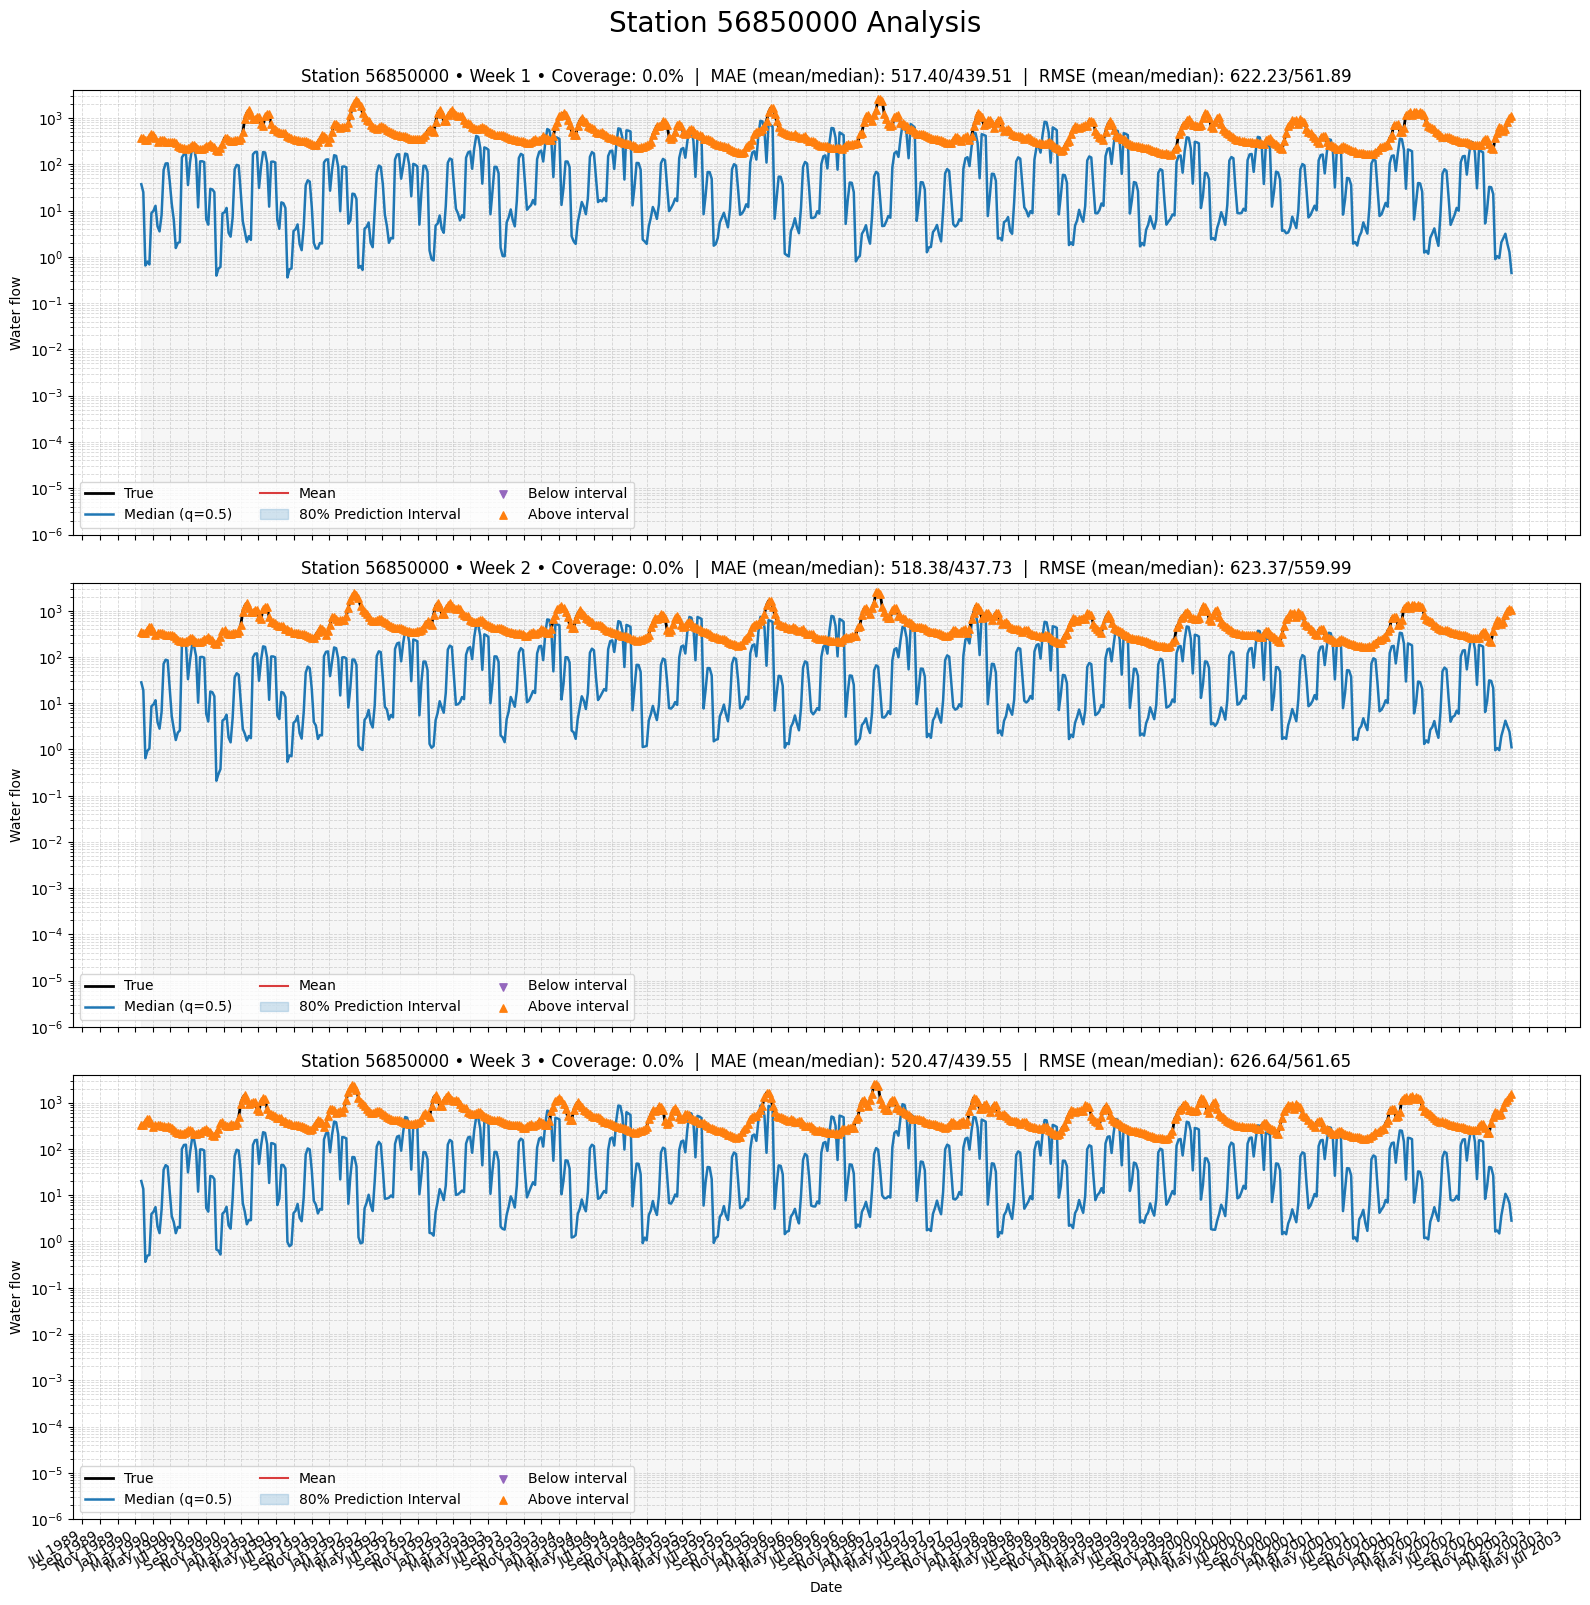

In [13]:
def plot_pred_by_station(results_df_to_plot):
    # results_df_to_plot = results_df_to_plot.copy()
    # add column with regression with mock values
    # results_df_to_plot["water_flow_week1_LGBM_regression"] = 0
    # results_df_to_plot["water_flow_week2_LGBM_regression"] = 0
    # results_df_to_plot["water_flow_week3_LGBM_regression"] = 0
    # # result_df_train_to_plot["water_flow_week4_LGBM_regression"] = 0

    station_ids = results_df_to_plot["station_code"].unique()
    station_id = np.random.choice(station_ids)

    fig, axes = plt.subplots(len(TARGETS), 1, figsize=(16, 16))
    plt.suptitle(f"Station {station_id} Analysis", fontsize=20, y=1.0)

    for week_pred in range(len(TARGETS)):
        plot_station_quantiles(
            axes[week_pred],
            results_df_to_plot,
            station_id,
            week_pred=week_pred + 1,
            q_lo=0.1,
            q_hi=0.9,
            use_logy=True,
            smooth_window=3,
        )
        fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()


for country in results_df_train.keys():
    print(f"Prediction plots for {country.capitalize()}:")
    plot_pred_by_station(results_df_train[country])

### Validation on spatio temporal and temporal valid data


In [14]:
# LOAD SAVED MODELS
all_models = {}
for country in results_storage_all.keys():
    file_path = results_storage_all[country]["file_path"]
    print(f"Loading models for {country.capitalize()} from: {file_path}")
    with open(
        file_path,
        "rb",
    ) as f:
        all_models[country] = pickle.load(f)

for target in TARGETS:
    print(f"--- Models for {target} ---")
    display(
        all_models["all"][target.replace("water_flow_", "").replace("week", "week_")][
            "LGBM_quantile_0.5"
        ]
    )

Loading models for All from: ../models2/run_2025-10-26_21-39-12/trained_models_on_split.pkl
--- Models for water_flow_week1 ---


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        feature_weights=None,
                                                        gamma=...
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   model__regressor__colsample_bytree=np.float64(0.6935133228268233),
                                                                   model__regressor__learning_rate=np.float64(0.10200680211778108),
                                                                   model__regressor__max_depth=4,
                                                                   model__regressor__min_child_weight=4, ...)))])

--- Models for water_flow_week2 ---


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        feature_weights=None,
                                                        gamma=...
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   model__regressor__colsample_bytree=np.float64(0.8313811040057837),
                                                                   model__regressor__learning_rate=np.float64(0.05740446517340904),
                                                                   model__regressor__max_depth=5,
                                                                   model__regressor__min_child_weight=10, ...)))])

--- Models for water_flow_week3 ---


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        feature_weights=None,
                                                        gamma=...
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   model__regressor__colsample_bytree=np.float64(0.6732376566743322),
                                                                   model__regressor__learning_rate=np.float64(0.06682910421729306),
                                                                   model__regressor__max_depth=3,
                                                                   model__regressor__min_child_weight=4, ...)))])

In [15]:
all_best_params = {}
for country in results_storage_all.keys():
    param_filename = results_storage_all[country]["all_params_path"]
    print(f"Loading best params from: {param_filename}")
    with open(
        param_filename,
        "rb",
    ) as f:
        all_best_params[country] = pickle.load(f)

Loading best params from: ../models2/run_2025-10-26_21-39-12/best_params_on_split.pkl


In [16]:
# sort test data by ObsDate and station_code
def valid_on_spatio_temporal_temporal_split_by_country(results_country, all_models):
    spatio_temporal_test = results_country["spatio_temporal_test"].copy()
    spatio_temporal_test = spatio_temporal_test.sort_values(
        by=["ObsDate", "station_code"]
    ).reset_index(drop=True)

    temporal_test = results_country["temporal_test"].copy()
    temporal_test = temporal_test.sort_values(
        by=["ObsDate", "station_code"]
    ).reset_index(drop=True)

    # predict
    pred_spatio_temporal, full_pred_spatio_temporal = run_test_pipeline_extended(
        all_models, spatio_temporal_test
    )
    pred_temporal, full_pred_temporal = run_test_pipeline_extended(
        all_models, temporal_test
    )

    for i in range(NUMBER_OF_WEEK):
        week = i + 1
        mse_spatio_temporal = mean_squared_error(
            spatio_temporal_test[f"water_flow_week{week}"],
            pred_spatio_temporal[f"week_{i}_pred"],
        )
        print(f"MSE Spatio-Temporal Test Week {week}: {mse_spatio_temporal}")

    for i in range(NUMBER_OF_WEEK):
        week = i + 1
        mse_temporal = mean_squared_error(
            temporal_test[f"water_flow_week{week}"],
            pred_temporal[f"week_{i}_pred"],
        )
        print(f"MSE Temporal Test Week {week}: {mse_temporal}")

    return {
        "pred_spatio_temporal": pred_spatio_temporal,
        "full_pred_spatio_temporal": full_pred_spatio_temporal,
        "pred_temporal": pred_temporal,
        "full_pred_temporal": full_pred_temporal,
    }


valid_spatio_temp_temp_by_country = {}
for country in results_storage_all.keys():
    print(f"Validation for {country.capitalize()}:")
    valid_spatio_temp_temp_by_country[country] = (
        valid_on_spatio_temporal_temporal_split_by_country(
            results_storage_all[country], all_models[country]
        )
    )

Validation for All:
MSE Spatio-Temporal Test Week 1: 69.09112312739025
MSE Spatio-Temporal Test Week 2: 193.6547226653836
MSE Spatio-Temporal Test Week 3: 318.4832267065239
MSE Temporal Test Week 1: 15445.693482574656
MSE Temporal Test Week 2: 24071.970934819587
MSE Temporal Test Week 3: 35764.1863656672


Prediction plots on Spatio_temporal Test Set for All:
Column water_flow_week1_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.


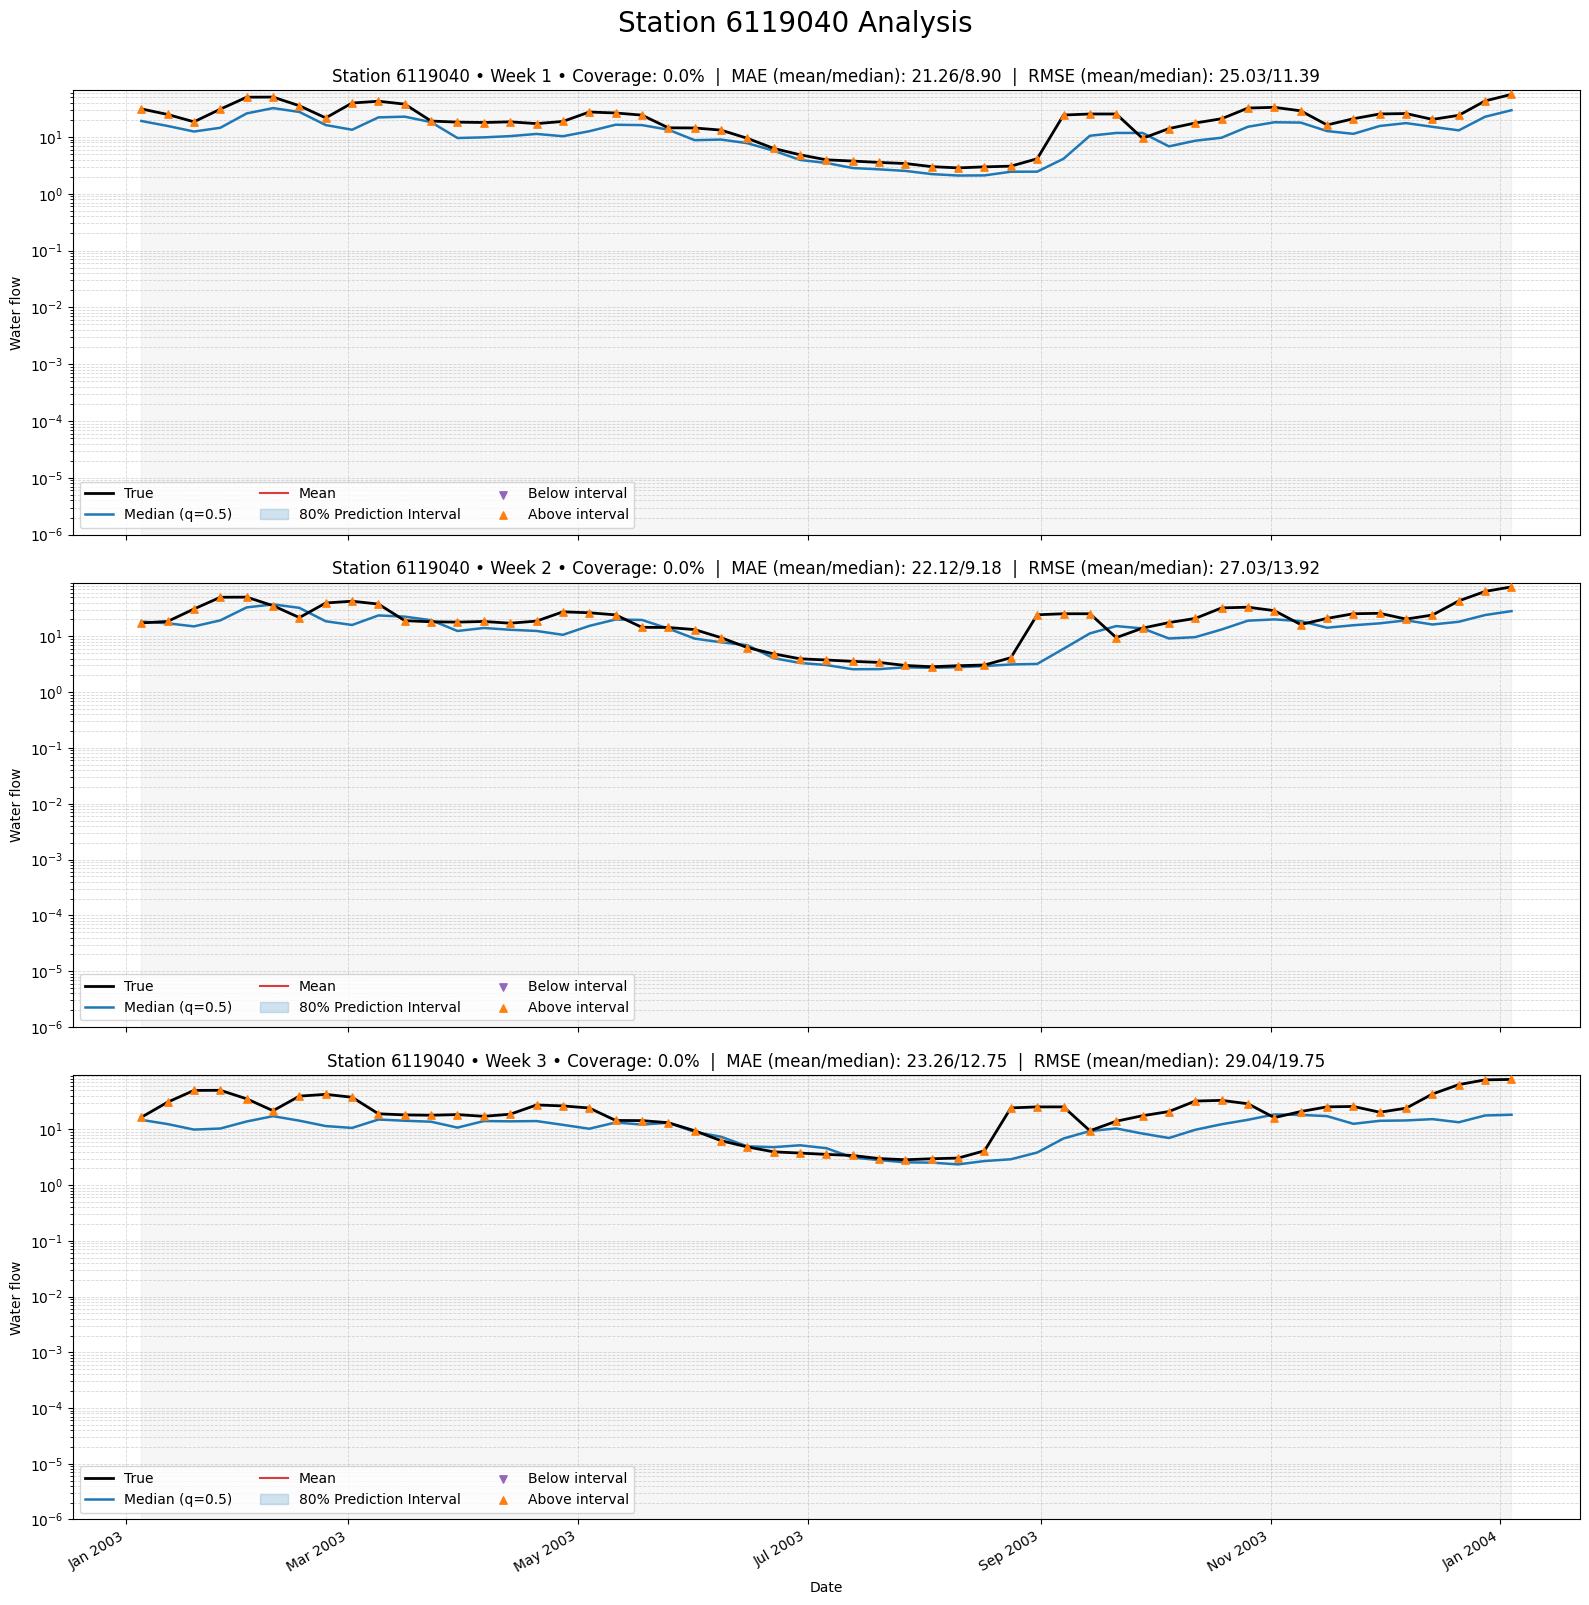

Prediction plots on Temporal Test Set for All:
Column water_flow_week1_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week1_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week2_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_regression not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.1 not found in DataFrame. Initializing to 0.
Column water_flow_week3_LGBM_quantile_0.9 not found in DataFrame. Initializing to 0.


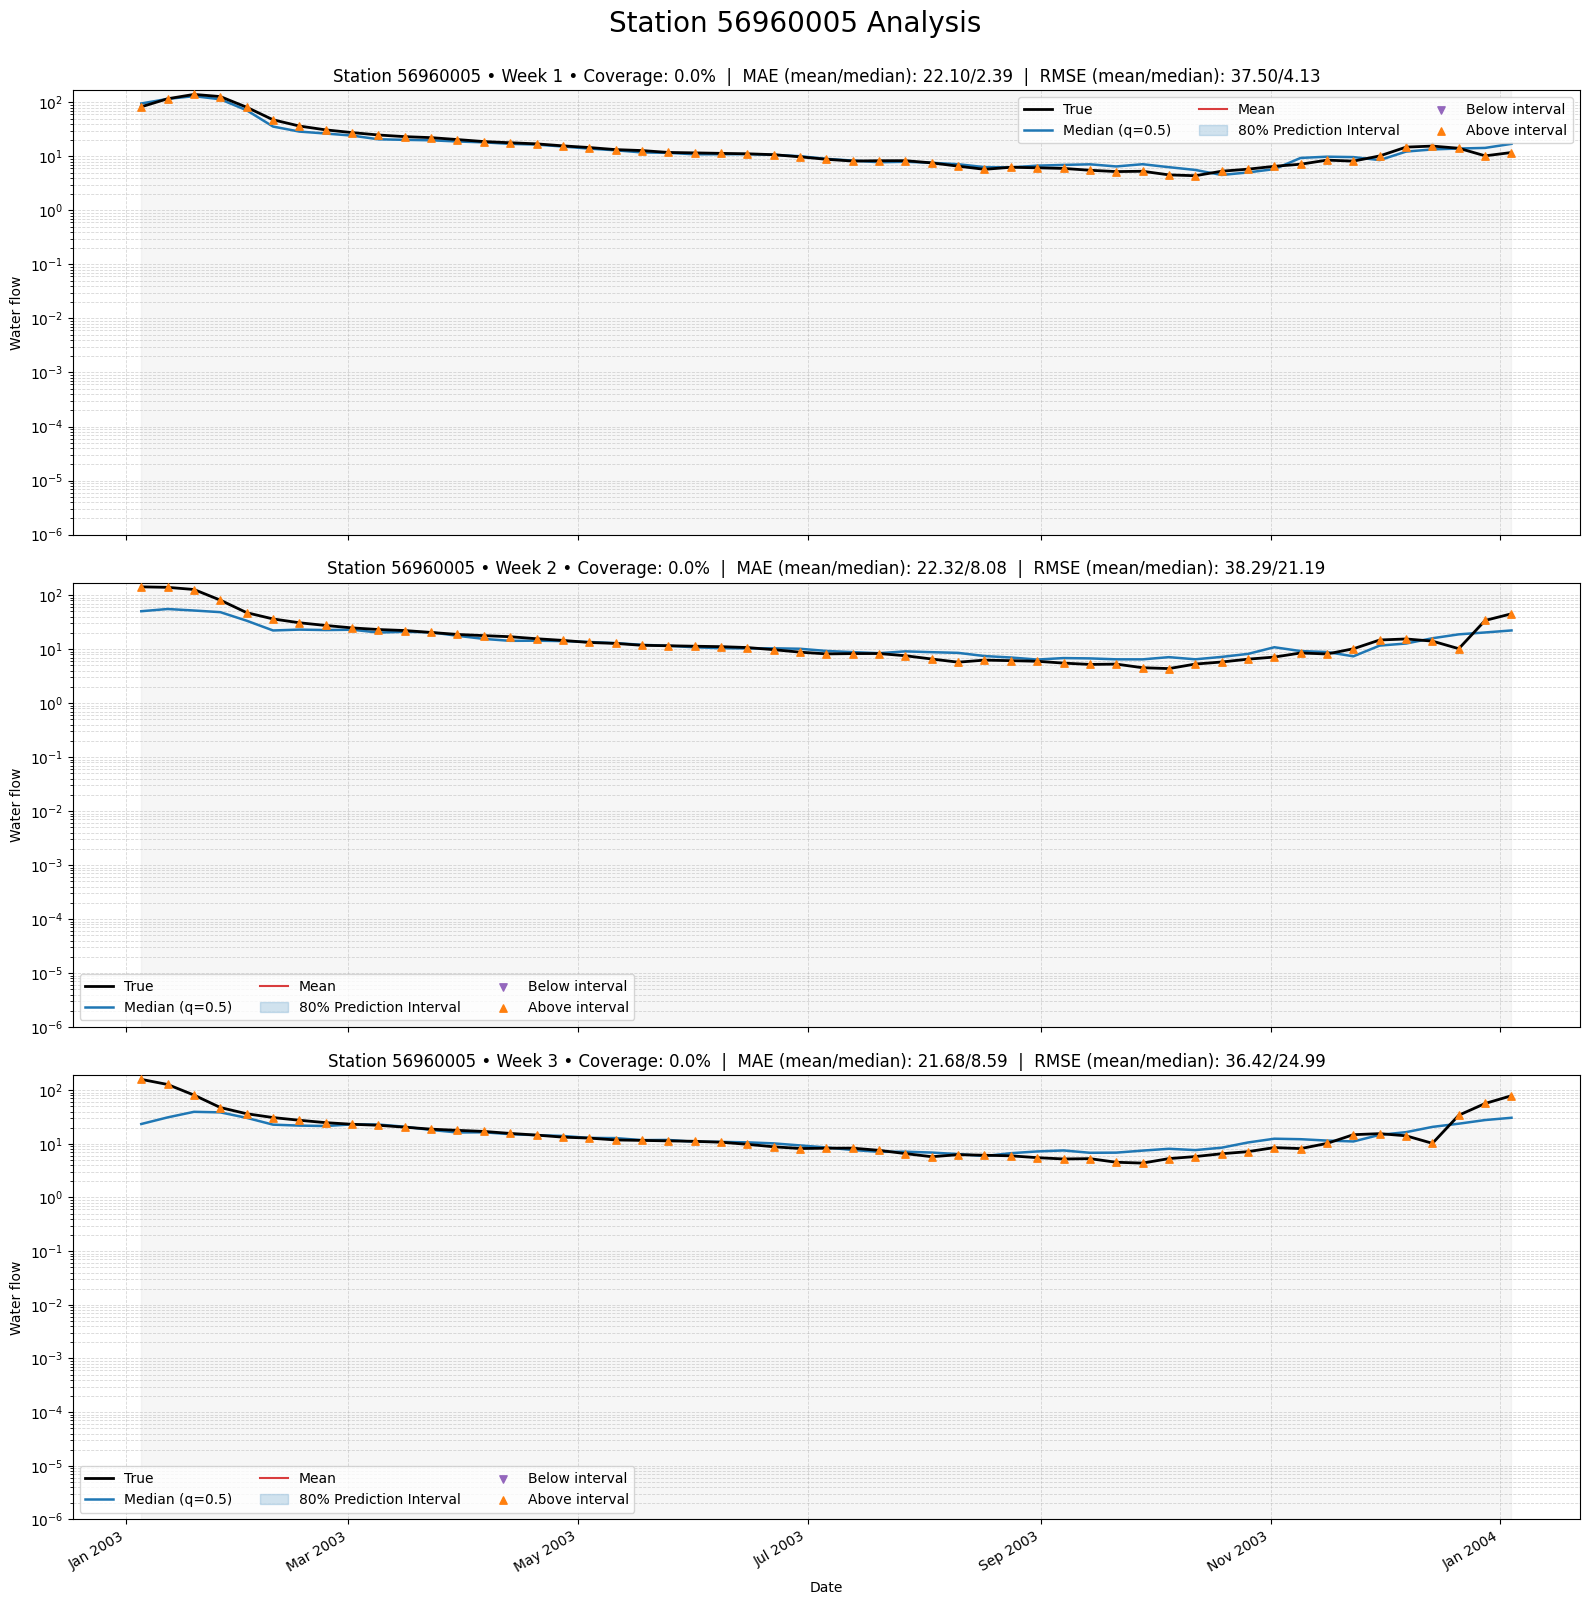

In [17]:
for country in valid_spatio_temp_temp_by_country.keys():
    for valid_set in [
        "spatio_temporal",
        "temporal",
    ]:
        print(
            f"Prediction plots on {valid_set.capitalize()} Test Set for {country.capitalize()}:"
        )
        plot_pred_by_station(
            valid_spatio_temp_temp_by_country[country][f"full_pred_{valid_set}"]
        )

### final training with best found parameters


In [18]:
def train_final_models_no_validation(
    Xtr,
    ytr,
    best_params,
    target_name,
    quantiles=[0.1, 0.5, 0.9],
    if_regression=False,
    if_quantiles=True,
):
    print(f"--- Training FINAL Models for: {target_name} ---")
    final_models = {}

    if if_quantiles:
        for q in quantiles:
            model_key = f"LGBM_quantile_{q}"
            print(f"Starting final fit for {model_key}...")

            # 1. Build quantile model using best_params
            # model_q = build_quantile_lgbm(alpha=q, params=best_params)
            model_q = build_model(
                type_model="xgb_regression", alpha=q, params=best_params
            )
            # model_q = build_regression_lgbm(params=best_params)

            # 2. Wrap model for transformation
            model_q_wrapped = build_wrapped_model_target_transf(model_q)
            # 3. Fit on full training data (no validation)
            # model_q_wrapped.fit(Xtr, ytr)
            preds, model_q_wrapped, carbon_results = fit_model(
                model_q_wrapped, Xtr, ytr, tracker_name=f"{target_name}_final_q_{q}"
            )

            final_models[model_key] = model_q_wrapped

    if if_regression:
        model_key = "LGBM_regression"
        print(f"Starting final fit for {model_key}...")

        # 1. Build regression model using best_params
        model_reg = build_regression_lgbm(params=best_params)

        # 2. Wrap model for transformation
        model_reg_wrapped = build_wrapped_model_target_transf(model_reg)

        # 3. Fit on full training data (no validation)
        model_reg_wrapped.fit(Xtr, ytr)

        final_models[model_key] = model_reg_wrapped

    print(f"--- Final Models for {target_name} Trained ---")
    return {"models": final_models, "carbon_results": carbon_results}


def train_final_models_all_targets(
    Xtr, ytr_all, best_params_all, quantiles=[0.1, 0.5, 0.9], seed=None
):
    """
    Loops through all targets and trains final models on the full training data.

    Args:
        Xtr (pd.DataFrame): Training features.
        ytr_all (pd.DataFrame): DataFrame containing all target variables.
        best_params_all (dict): Dictionary mapping each target to its best hyperparameters.
        quantiles (list): List of quantile levels to train models for.
    Returns:
        dict: A dictionary containing all trained models for each target.
    """
    results = {}

    for i, target in enumerate(TARGETS):
        print(f"\n=== Training FINAL models for {target} ===")
        ytr = ytr_all[target]

        best_params = best_params_all.get(target, {})

        if seed is not None:
            print(f"Setting random_state to {seed} for reproducibility.")
            best_params["random_state"] = seed

        target_results = train_final_models_no_validation(
            Xtr,
            ytr,
            best_params=best_params,
            target_name=target,
            quantiles=quantiles,
            if_regression=False,
            if_quantiles=True,
        )

        # 3. Store results
        results[target] = {
            **target_results,  # Unpack models, preds, carbon_results
            "true": ytr.values,
        }

    print("\n=== FINAL Training complete ===")
    return results


def run_final_training_no_validation(
    train_df, all_best_params, quantiles=[0.1, 0.5, 0.9], seed=None
):
    """
    Main function to run the complete final training pipeline on full data.

    Args:
        df: The initial dataframe.
        all_best_params: Dictionary of best parameters for each target.
        quantiles: List of quantiles to train models for.
    """
    # 1. Process data
    print("Processing data for final training...")
    train_df = process_df(train_df)

    # 2. Split data
    Xtr = train_df.drop(columns=TO_DROP)
    ytr_all = train_df[TARGETS]

    print(f"training on full data {Xtr.shape}, {ytr_all.shape}")
    # 3. Train all final models
    results = train_final_models_all_targets(
        Xtr, ytr_all, all_best_params, quantiles=quantiles, seed=seed
    )

    return results

In [19]:
import random


def run_final_training_pipeline_by_country(
    dataset_train,
    all_best_params_by_country,
    quantiles=[0.1, 0.5, 0.9],
    seed=None,
):
    final_results_storage = {}

    for country_name, hemisphere_status in {
        "france": 1,
        "brazil": 0,
    }.items():
        dataset_filtered = dataset_train[
            dataset_train["north_hemisphere"] == hemisphere_status
        ].reset_index(drop=True)

        print(
            f"Starting FINAL training pipeline for {country_name.capitalize()} (Hemisphere: {hemisphere_status})..."
        )

        final_results_storage[country_name] = run_final_training_no_validation(
            train_df=dataset_filtered,
            all_best_params=all_best_params_by_country[country_name],
            quantiles=quantiles,
            seed=seed,
        )

        final_results_storage[country_name]["save_dir"] = save_models_directory(
            final_results_storage[country_name],
            all_best_params=all_best_params_by_country[country_name],
            filename=f"final_trained_models_{country_name}.pkl",
            param_filename=f"final_best_params_{country_name}.pkl",
        )

    return final_results_storage


def run_final_training_pipeline_all(
    dataset_train,
    all_best_params_by_country,
    quantiles=[0.1, 0.5, 0.9],
    seed=None,
):
    final_results_storage = {}
    country_name = "all"
    dataset_filtered = dataset_train.copy()
    print(
        f"Starting FINAL training pipeline for {country_name.capitalize()} (All Data)..."
    )

    final_results_storage[country_name] = run_final_training_no_validation(
        train_df=dataset_filtered,
        all_best_params=all_best_params_by_country[country_name],
        quantiles=quantiles,
        seed=seed,
    )

    final_results_storage[country_name]["save_dir"] = save_models_directory(
        final_results_storage[country_name],
        all_best_params=all_best_params_by_country[country_name],
        filename=f"final_trained_models_{country_name}.pkl",
        param_filename=f"final_best_params_{country_name}.pkl",
    )

    return final_results_storage


def run_bagging_final_training_pipeline_by_country(
    seeds, dataset_train, all_best_params, quantiles=QUANTILES
):
    bagged_results_storage = {}
    for s in seeds:
        print(f"\n=== Bagging Run with Seed {s} ===")
        np.random.seed(s)
        random.seed(s)
        bagged_results = run_final_training_pipeline_by_country(
            dataset_train,
            all_best_params,
            quantiles=quantiles,
            seed=s,
        )
        bagged_results_storage[f"seed_{s}"] = bagged_results

    return bagged_results_storage


def run_bagging_final_training_pipeline_all(
    seeds, dataset_train, all_best_params, quantiles=QUANTILES
):
    bagged_results_storage = {}
    for s in seeds:
        print(f"\n=== Bagging Run with Seed {s} ===")
        np.random.seed(s)
        random.seed(s)
        bagged_results = run_final_training_pipeline_all(
            dataset_train,
            all_best_params,
            quantiles=quantiles,
            seed=s,
        )
        bagged_results_storage[f"seed_{s}"] = bagged_results

    return bagged_results_storage

In [34]:
# print best params for all weeks
print("=== BEST PARAMS FOR ALL WEEKS (FINAL MODELS) ===")
for target in TARGETS:
    print(f"--- {target} ---")
    for key, value in all_best_params["all"][target].items():
        if isinstance(value, float):
            print(f"{key}: {value:.6f}")
        else:
            print(f"{key}: {value}")

=== BEST PARAMS FOR ALL WEEKS (FINAL MODELS) ===
--- water_flow_week1 ---
imputer__strategy: mean
model__regressor__colsample_bytree: 0.693513
model__regressor__learning_rate: 0.102007
model__regressor__max_depth: 4
model__regressor__min_child_weight: 4
model__regressor__n_estimators: 1821
model__regressor__objective: reg:pseudohubererror
model__regressor__reg_alpha: 0.375760
model__regressor__reg_lambda: 11.107417
model__regressor__subsample: 0.734926
selector__threshold: median
random_state: 999
--- water_flow_week2 ---
imputer__strategy: median
model__regressor__colsample_bytree: 0.831381
model__regressor__learning_rate: 0.057404
model__regressor__max_depth: 5
model__regressor__min_child_weight: 10
model__regressor__n_estimators: 1040
model__regressor__objective: reg:pseudohubererror
model__regressor__reg_alpha: 10.979516
model__regressor__reg_lambda: 11.200463
model__regressor__subsample: 0.734835
selector__threshold: median
random_state: 999
--- water_flow_week3 ---
imputer__strat

In [21]:
# 1 seed
# final_results_storage = run_final_training_pipeline_by_country(
#     dataset_train, all_best_params, quantiles=QUANTILES
# )

# seeds for bagging
seeds = [42, 2023, 7, 1234, 0, 999]
bagged_final_results_storage = run_bagging_final_training_pipeline_all(
    seeds, dataset_train, all_best_params, quantiles=QUANTILES
)


=== Bagging Run with Seed 42 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...


[codecarbon WARNING @ 21:39:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:15] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:15] We saw that you have a Apple M3 but we don't know it. Please contact us.


training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 42 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:20] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:20] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 42 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:22] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:22] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:22] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 42 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:24] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-39-24/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-39-24/final_best_params_all.pkl

=== Bagging Run with Seed 2023 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...
training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 2023 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:24] We saw that you have a Apple M3 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:39:25] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:26] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:27] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 2023 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:29] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:29] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:29] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 2023 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:31] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:31] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-39-31/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-39-31/final_best_params_all.pkl

=== Bagging Run with Seed 7 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...
training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 7 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:31] We saw that you have a Apple M3 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:39:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:34] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:34] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 7 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:36] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:36] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 7 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:36] No CPU tracking mode found. Falling back on CPU constant mode.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-39-38/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-39-38/final_best_params_all.pkl

=== Bagging Run with Seed 1234 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...


[codecarbon WARNING @ 21:39:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:39] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:39] We saw that you have a Apple M3 but we don't know it. Please contact us.


training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 1234 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:44] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:44] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 1234 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:47] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:47] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:47] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 1234 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:50] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-39-49/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-39-49/final_best_params_all.pkl

=== Bagging Run with Seed 0 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...
training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 0 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:50] We saw that you have a Apple M3 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:39:50] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:52] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:52] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 0 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:54] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:54] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 0 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:57] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-39-57/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-39-57/final_best_params_all.pkl

=== Bagging Run with Seed 999 ===
Starting FINAL training pipeline for All (All Data)...
Processing data for final training...
training on full data (28431, 243), (28431, 3)

=== Training FINAL models for water_flow_week1 ===
Setting random_state to 999 for reproducibility.
--- Training FINAL Models for: water_flow_week1 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:39:57] We saw that you have a Apple M3 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:39:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:39:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:39:59] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:39:59] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:39:59] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week1 Trained ---

=== Training FINAL models for water_flow_week2 ===
Setting random_state to 999 for reproducibility.
--- Training FINAL Models for: water_flow_week2 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:40:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:40:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:40:02] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:40:02] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon WARNING @ 21:40:02] We saw that you have a Apple M3 but we don't know it. Please contact us.


--- Final Models for water_flow_week2 Trained ---

=== Training FINAL models for water_flow_week3 ===
Setting random_state to 999 for reproducibility.
--- Training FINAL Models for: water_flow_week3 ---
Starting final fit for LGBM_quantile_0.5...


[codecarbon WARNING @ 21:40:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 21:40:02] No CPU tracking mode found. Falling back on CPU constant mode.


--- Final Models for water_flow_week3 Trained ---

=== FINAL Training complete ===
✅ Saved all models for all weeks to: ../models2/run_2025-10-26_21-40-04/final_trained_models_all.pkl
✅ Saved all params for all weeks to: ../models2/run_2025-10-26_21-40-04/final_best_params_all.pkl


In [29]:
# print all carbon results for one seed
for week in TARGETS:
    print(f"=== {week} ===")
    for key, value in bagged_final_results_storage["seed_42"]["all"][week][
        "carbon_results"
    ].items():
        print(f"{key}: {value:.8f}")

=== water_flow_week1 ===
duration_seconds: 1.63725591
emissions_kg: 0.00000116
cpu_energy_kwh: 0.00002068
=== water_flow_week2 ===
duration_seconds: 1.59149003
emissions_kg: 0.00000113
cpu_energy_kwh: 0.00002010
=== water_flow_week3 ===
duration_seconds: 1.61778688
emissions_kg: 0.00000115
cpu_energy_kwh: 0.00002044


### predictions on public test data


In [23]:
# save the predictions to a csv file


def test_by_country(dataset_test, all_models_by_country):
    regions_hemispheres = {
        "france": 1,  # 1 for Northern Hemisphere
        "brazil": 0,  # 0 for Southern Hemisphere
    }

    # Loop over each region and its hemisphere status
    predictions_by_country = {}
    full_pred_test_by_country = {}

    for country_name, hemisphere_status in regions_hemispheres.items():
        dataset_filtered = dataset_test[
            dataset_test["north_hemisphere"] == hemisphere_status
        ].reset_index(drop=True)

        all_models = all_models_by_country[country_name]

        (
            predictions_by_country[country_name],
            full_pred_test_by_country[country_name],
        ) = run_test_pipeline_extended(all_models, dataset_filtered)

    return {
        "predictions": predictions_by_country,
        "full_predictions": full_pred_test_by_country,
    }


# launch training pipeline by country and merge results by raising error if conflicts in id columns
def test_all(dataset_test, all_models_by_country):
    dataset_filtered = dataset_test.copy()
    # Loop over each region and its hemisphere status
    predictions_by_country = {}
    full_pred_test_by_country = {}
    for country_name in all_models_by_country.keys():
        all_models = all_models_by_country[country_name]

        (
            predictions_by_country[country_name],
            full_pred_test_by_country[country_name],
        ) = run_test_pipeline_extended(all_models, dataset_filtered)

    return {
        "predictions": predictions_by_country,
        "full_predictions": full_pred_test_by_country,
    }


def merge_predictions_by_country(predictions_by_country):
    # Merge predictions by raising error if conflicts in id columns
    predictions_merged = None
    for country_name, preds in predictions_by_country.items():
        if predictions_merged is None:
            predictions_merged = preds
        else:
            # Check for conflicts in 'id' column
            print(predictions_merged["id"].head())
            print(preds["id"].head())
            common_ids = set(predictions_merged["id"]).intersection(set(preds["id"]))
            if common_ids:
                raise ValueError(
                    f"Conflict in 'id' column between countries: {common_ids}"
                )
            predictions_merged = pd.concat(
                [predictions_merged, preds], ignore_index=True
            )
    return predictions_merged


def get_all_models_by_country(final_results_storage):
    all_models_by_country = {}
    for country in final_results_storage.keys():
        all_models_by_country[country] = {}
        for i in range(NUMBER_OF_WEEK):
            week = i + 1
            all_models_by_country[country][f"week_{week}"] = final_results_storage[
                country
            ][f"water_flow_week{week}"]["models"]
    return all_models_by_country


def predict_pipeline_1_seed(final_results_storage, dataset_test):
    all_models_by_country = get_all_models_by_country(final_results_storage)

    test_results = test_by_country(dataset_test, all_models_by_country)
    predictions_merged = merge_predictions_by_country(test_results["predictions"])

    for country in test_results["predictions"].keys():
        display(test_results["predictions"][country].head())

    return predictions_merged


def predict_pipeline_1_seed_all(final_results_storage, dataset_test):
    all_models_by_country = get_all_models_by_country(final_results_storage)

    test_results = test_all(dataset_test, all_models_by_country)
    predictions_merged = merge_predictions_by_country(test_results["predictions"])

    for country in test_results["predictions"].keys():
        display(test_results["predictions"][country].head())

    return predictions_merged


def predict_pipeline_bagging(bagged_final_results_storage, dataset_test, seeds):
    # 1. Collect all prediction DataFrames
    all_predictions_dfs = {}

    for s in seeds:
        # ⚠️ NOTE: The final_results_storage must contain the trained model
        # or the necessary info to generate predictions for the current seed.
        final_results_storage = bagged_final_results_storage[f"seed_{s}"]

        # predictions_merged is expected to be a DataFrame (id, pred_quantile_1, ...)
        predictions_merged = predict_pipeline_1_seed(
            final_results_storage, dataset_test
        )

        # Ensure 'id' column is set as index for easy merging/alignment
        predictions_merged = predictions_merged.set_index("id")
        all_predictions_dfs[s] = predictions_merged

    # 2a. Concatenate all prediction dataframes vertically
    combined_predictions = pd.concat(list(all_predictions_dfs.values()))
    # check combined_predictions shape
    print("Combined predictions shape (before averaging):", combined_predictions.shape)

    # 2b. Group by the index ('id') and calculate the mean of all columns
    predictions_avg = combined_predictions.groupby(level=0).mean()
    # check predictions_avg shape
    print("Averaged predictions shape:", predictions_avg.shape)
    # Reset the index to make 'id' a column again, matching the expected output format
    return predictions_avg.reset_index(), combined_predictions


def predict_pipeline_bagging_all(bagged_final_results_storage, dataset_test, seeds):
    # 1. Collect all prediction DataFrames
    all_predictions_dfs = {}

    for s in seeds:
        # ⚠️ NOTE: The final_results_storage must contain the trained model
        # or the necessary info to generate predictions for the current seed.
        final_results_storage = bagged_final_results_storage[f"seed_{s}"]

        # predictions_merged is expected to be a DataFrame (id, pred_quantile_1, ...)
        predictions_merged = predict_pipeline_1_seed_all(
            final_results_storage, dataset_test
        )

        # Ensure 'id' column is set as index for easy merging/alignment
        predictions_merged = predictions_merged.set_index("id")
        all_predictions_dfs[s] = predictions_merged

    # 2a. Concatenate all prediction dataframes vertically
    combined_predictions = pd.concat(list(all_predictions_dfs.values()))
    # check combined_predictions shape
    print("Combined predictions shape (before averaging):", combined_predictions.shape)

    # 2b. Group by the index ('id') and calculate the mean of all columns
    predictions_avg = combined_predictions.groupby(level=0).mean()
    # check predictions_avg shape
    print("Averaged predictions shape:", predictions_avg.shape)
    # Reset the index to make 'id' a column again, matching the expected output format
    return predictions_avg.reset_index(), combined_predictions


# print("predictions_merged 1 seed")
# predictions_merged = predict_pipeline_1_seed(final_results_storage, dataset_test)
# display(predictions_merged.head())

print("predictions_merged bagging")
predictions_merged_bagging, combined_predictions_bagging = predict_pipeline_bagging_all(
    bagged_final_results_storage, dataset_test, seeds
)
display(predictions_merged_bagging.head())

predictions_merged bagging


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


,id,week_0_pred,week_1_pred,week_2_pred
0,6119020_2004-02-01,50.560062,26.933424,28.524017
1,6119030_2004-02-01,123.046715,56.735897,42.289669
2,6119040_2004-02-01,74.267952,50.137512,25.374491
3,6119110_2004-02-01,4.280877,4.231686,11.199096
4,6119120_2004-02-01,22.181177,5.219823,10.120573


Combined predictions shape (before averaging): (8112, 3)
Averaged predictions shape: (1352, 3)


,id,week_0_pred,week_1_pred,week_2_pred
0,56425000_2004-02-01,248.376511,257.733124,203.357498
1,56425000_2004-04-25,315.990265,154.277847,141.047974
2,56425000_2004-07-18,112.152496,109.859688,112.670021
3,56425000_2004-10-10,92.513954,120.978577,124.905449
4,56425000_2005-01-02,269.165131,230.688232,342.375397


In [24]:
display(predictions_merged_bagging)

,id,week_0_pred,week_1_pred,week_2_pred
0,56425000_2004-02-01,248.376511,257.733124,203.357498
1,56425000_2004-04-25,315.990265,154.277847,141.047974
2,56425000_2004-07-18,112.152496,109.859688,112.670021
3,56425000_2004-10-10,92.513954,120.978577,124.905449
4,56425000_2005-01-02,269.165131,230.688232,342.375397
...,...,...,...,...
1347,6939050_2008-11-30,314.744202,360.198486,422.742340
1348,6939050_2009-02-22,383.798248,392.373505,360.471924
1349,6939050_2009-05-17,233.591492,329.211273,257.054962
1350,6939050_2009-08-09,460.471313,900.875732,387.240356


In [25]:
# predictions.drop(columns=["week_3_pred"], inplace=True)
predictions_merged_bagging.to_csv(
    f"../../preds/predictions_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv",
    index=False,
)
predictions_merged_bagging.head()

,id,week_0_pred,week_1_pred,week_2_pred
0,56425000_2004-02-01,248.376511,257.733124,203.357498
1,56425000_2004-04-25,315.990265,154.277847,141.047974
2,56425000_2004-07-18,112.152496,109.859688,112.670021
3,56425000_2004-10-10,92.513954,120.978577,124.905449
4,56425000_2005-01-02,269.165131,230.688232,342.375397


In [26]:
import os

print(os.getcwd())

/Users/julesroyer/Code/IDSC-CODE/data-challenge-capgemini/data_challenge_mines2025/src2/notebooks


In [57]:
import pandas as pd

for target in TARGETS:
    print(f"=== Feature importance for {target} ===")

    # 1. Get the TransformedTargetRegressor object
    ttr_object = bagged_final_results_storage["seed_42"]["all"][target]["models"][
        "LGBM_quantile_0.5"
    ]["model"]

    # 2. Get the inner pipeline (that processes X) from the TTR
    #    This is the object that has .get_feature_names_out()
    pipeline_X = ttr_object.regressor_

    # 3. Get the FINAL MODEL from the last step of the inner pipeline
    #    (Assuming the last step is named 'model')
    model_to_inspect = pipeline_X.named_steps["model"]

    # 4. Get importances from the FINAL MODEL
    feature_importances = model_to_inspect.feature_importances_

    # 5. Get feature names from the INNER PIPELINE
    feature_names = pipeline_X.get_feature_names_out()

    # 6. Create the DataFrame. The lengths will now match.
    feature_importance_df = pd.DataFrame(
        {
            "feature": feature_names,
            "importance": feature_importances,
        }
    ).sort_values(by="importance", ascending=False)

    display(feature_importance_df.head(100))

=== Feature importance for water_flow_week1 ===


AttributeError: 'XGBRegressor' object has no attribute 'named_steps'